# Semantic Image Search with CLIP

In this notebook, you will:

1. **Understand** what CLIP is and how it connects images and text
2. **Load** the CLIP model (downloaded once, cached locally)
3. **Compute** CLIP embeddings for your downloaded image collection
4. **Search** the collection using natural language queries
5. **Compare** different query strategies and prompt techniques

---

## What is CLIP?

**CLIP** (Contrastive Language–Image Pre-Training) is a neural network by OpenAI
that understands both images and text in a *shared* semantic space.

Instead of being trained to classify images into fixed categories, CLIP was trained
on **400 million image–text pairs** from the internet — learning to match images with
their captions.

![European Cultural Heritage Collections](../misc/assets/img/clip.svg)

### The Key Idea

CLIP encodes both images and text into the same 512-dimensional space.
Similar concepts end up *close together*:

```
"a river landscape"    ←→  🖼️  painting of a river
"portrait of a woman"  ←→  🖼️  portrait painting
"boats at sea"         ←→  🖼️  seascape with ships
```

This means you can search an image collection **using plain English** —
no manual tagging needed.

```mermaid
flowchart LR
    TEXT["📝 Text\n\"a river landscape\""]
    IMAGE["🖼️ Image\n(painting)"]
    SPACE["📐 Shared\nEmbedding Space\n(512 dimensions)"]
    SIM["📊 Cosine\nSimilarity"]

    TEXT  -->|"Text Encoder"| SPACE
    IMAGE -->|"Image Encoder"| SPACE
    SPACE --> SIM
```


---

## Part 1: Setup

In [52]:
# Standard library
import json
import time
from pathlib import Path

# Numerical & image
import numpy as np
from PIL import Image as PILImage

# Jupyter display
from IPython.display import display, Image

# PyTorch + CLIP
try:
    import torch
    import clip
    CLIP_AVAILABLE = True
    print("✓ CLIP loaded successfully!")
except ImportError:
    CLIP_AVAILABLE = False
    print("❌ CLIP not installed.")
    print("   pip install git+https://github.com/openai/CLIP.git torch torchvision")

# Select compute device: CUDA GPU > Apple Silicon > CPU
if CLIP_AVAILABLE:
    if torch.cuda.is_available():
        DEVICE = 'cuda'
        print(f"✓ GPU (CUDA): {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        DEVICE = 'mps'
        print("✓ Apple Silicon GPU (MPS)")
    else:
        DEVICE = 'cpu'
        print("ℹ️  No GPU — using CPU (fine for small collections)")


✓ CLIP loaded successfully!
✓ GPU (CUDA): NVIDIA RTX A1000 6GB Laptop GPU


In [53]:
# Paths — must match the configuration used in Notebook 02
CURRENT_DIR  = Path.cwd()
PROJECT_ROOT = CURRENT_DIR.parent
DATA_DIR     = PROJECT_ROOT / "data"

# ============================================================
# CONFIGURATION — change to match your Notebook 02 settings!
# ============================================================

COLLECTION_NAME = "Museum of Gothenburg"  # same as in Notebook 02
THEME           = "art"                   # same as in Notebook 02
SEARCH_KEYWORD  = None                    # same as in Notebook 02

# CLIP model
MODEL_NAME = "ViT-B/32"                  # good balance of speed and quality

# ============================================================
# Auto-generate paths (same logic as Notebook 02)
# ============================================================

_parts = [COLLECTION_NAME.replace(' ', '_')]
if THEME:           _parts.append(THEME)
if SEARCH_KEYWORD:  _parts.append(SEARCH_KEYWORD)
_folder_name = "_".join(_parts)

COLLECTION_IMAGES_DIR      = DATA_DIR / "images"     / _folder_name
COLLECTION_EMBEDDINGS_FILE = DATA_DIR / "embeddings" / _folder_name / f"{_folder_name}_clip_embeddings.npz"
COLLECTION_EMBEDDINGS_FILE.parent.mkdir(parents=True, exist_ok=True)

# Folder where the CLIP model weights are cached
CLIP_MODEL_DIR = PROJECT_ROOT / "models" / "CLIP"
CLIP_MODEL_DIR.mkdir(parents=True, exist_ok=True)

print(f"Collection : {COLLECTION_NAME}")
print(f"Theme      : {THEME or '(all)'}")
print(f"Keyword    : {SEARCH_KEYWORD or '(all)'}")
print(f"Images     : {COLLECTION_IMAGES_DIR}")
print(f"Embeddings : {COLLECTION_EMBEDDINGS_FILE}")
print(f"CLIP model : {CLIP_MODEL_DIR}")
print(f"Images exist: {COLLECTION_IMAGES_DIR.exists()} "
      f"({len(list(COLLECTION_IMAGES_DIR.glob('*.jpg'))) if COLLECTION_IMAGES_DIR.exists() else 0} files)")


Collection : Museum of Gothenburg
Theme      : art
Keyword    : (all)
Images     : /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/images/Museum_of_Gothenburg_art
Embeddings : /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/embeddings/Museum_of_Gothenburg_art/Museum_of_Gothenburg_art_clip_embeddings.npz
CLIP model : /home/lauhp/000_PHD/000_003_Code/DH-Workshop/models/CLIP
Images exist: True (200 files)


---

## Part 2: Load the CLIP Model

The model weights (~350 MB for ViT-B/32) are downloaded on the first run
and cached in `models/CLIP/` — subsequent runs load instantly from disk.

| Model | Dimensions | Speed | Quality |
|-------|-----------|-------|---------|
| `RN50` | 1024 | Fast | Good |
| `ViT-B/32` | 512 | Fast | Good ✓ |
| `ViT-B/16` | 512 | Medium | Better |
| `ViT-L/14` | 768 | Slow | Best |


In [54]:
if CLIP_AVAILABLE:
    print(f"Loading CLIP model '{MODEL_NAME}'...")
    print(f"  Cache: {CLIP_MODEL_DIR}")

    # download_root tells CLIP where to save / look for model weights
    model, preprocess = clip.load(MODEL_NAME, device=DEVICE,
                                  download_root=str(CLIP_MODEL_DIR))
    model.eval()
    print(f"✓ Model ready on {DEVICE}")
else:
    print("❌ CLIP not available — install it first (see imports cell)")


Loading CLIP model 'ViT-B/32'...
  Cache: /home/lauhp/000_PHD/000_003_Code/DH-Workshop/models/CLIP


100%|███████████████████████████████████████| 338M/338M [01:40<00:00, 3.52MiB/s]


✓ Model ready on cuda


---

## Part 3: Compute Embeddings

An **embedding** is a list of numbers (a vector) that encodes the *meaning* of an image.
CLIP's image encoder produces a 512-number vector for each image — images with similar
visual content end up with similar vectors.

We process all downloaded images in **batches**, normalize each embedding to length 1,
and save everything to a compressed `.npz` file so we never have to recompute.

```
Image → resize & normalise → CLIP image encoder → 512-dim vector → save to .npz
```

In [55]:
import ipywidgets as widgets

# Scan data/images/ for folders that actually contain images
_images_root = DATA_DIR / "images"
_available   = sorted([
    d.name for d in _images_root.iterdir()
    if d.is_dir() and any(d.glob("*.jpg"))
]) if _images_root.exists() else []

if not _available:
    print("⚠️  No image folders found in data/images/")
    print("   Run Notebook 02 first to download images.")
    folder_selector = None
else:
    _default = _folder_name if _folder_name in _available else _available[0]

    folder_selector = widgets.Dropdown(
        options=_available,
        value=_default,
        description="Image folder:",
        style={"description_width": "initial"},
        layout=widgets.Layout(width="550px"),
    )

    _info = widgets.HTML(value="")

    def _update_info(change=None):
        sel  = folder_selector.value
        n    = len(list((_images_root / sel).glob("*.jpg")))
        npz  = DATA_DIR / "embeddings" / sel / f"{sel}_clip_embeddings.npz"
        emb  = "✓ embeddings exist" if npz.exists() else "no embeddings yet"
        _info.value = f"<span style='color:grey'>{n} images · {emb}</span>"

    folder_selector.observe(lambda c: _update_info(c), names="value")
    _update_info()

    display(widgets.VBox([folder_selector, _info]))
    print("Select a folder, then run the next cell to compute embeddings.")


Select a folder, then run the next cell to compute embeddings.


In [56]:
# Resolve paths from the dropdown above (falls back to paths cell if widget not shown)
_sel_folder            = folder_selector.value if folder_selector else _folder_name
COLLECTION_IMAGES_DIR      = DATA_DIR / "images"     / _sel_folder
COLLECTION_EMBEDDINGS_FILE = DATA_DIR / "embeddings" / _sel_folder / f"{_sel_folder}_clip_embeddings.npz"
COLLECTION_EMBEDDINGS_FILE.parent.mkdir(parents=True, exist_ok=True)

print(f"Folder     : {_sel_folder}")
print(f"Images     : {COLLECTION_IMAGES_DIR}")
print(f"Embeddings : {COLLECTION_EMBEDDINGS_FILE}")
print()

BATCH_SIZE = 32  # reduce to 8 if you run out of GPU memory

if not CLIP_AVAILABLE:
    print("❌ CLIP not available")
elif COLLECTION_EMBEDDINGS_FILE.exists():
    print("✓ Embeddings already exist — skipping computation.")
    print(f"  Delete {COLLECTION_EMBEDDINGS_FILE.name} and re-run to recompute.")
else:
    image_files = sorted(
        f for f in COLLECTION_IMAGES_DIR.glob('*')
        if f.suffix.lower() in ('.jpg', '.jpeg', '.png', '.webp')
    )

    if not image_files:
        print(f"⚠️  No images found in {COLLECTION_IMAGES_DIR}")
        print("   Run Notebook 02 first to download images.")
    else:
        print(f"Computing embeddings for {len(image_files)} images...")
        print(f"  Model: {MODEL_NAME}  |  Device: {DEVICE}  |  Batch: {BATCH_SIZE}")
        print()

        all_embeddings = []
        all_filenames  = []
        failed         = []
        t0             = time.time()

        for i in range(0, len(image_files), BATCH_SIZE):
            batch_files   = image_files[i : i + BATCH_SIZE]
            batch_tensors = []
            batch_names   = []

            for img_path in batch_files:
                try:
                    img = PILImage.open(img_path).convert('RGB')
                    batch_tensors.append(preprocess(img))
                    batch_names.append(img_path.name)
                except Exception as e:
                    failed.append((img_path.name, str(e)))

            if batch_tensors:
                with torch.no_grad():
                    batch = torch.stack(batch_tensors).to(DEVICE)
                    emb   = model.encode_image(batch).float()
                    emb   = emb / emb.norm(dim=-1, keepdim=True)
                all_embeddings.append(emb.cpu().numpy())
                all_filenames.extend(batch_names)

            done = min(i + BATCH_SIZE, len(image_files))
            if done % (BATCH_SIZE * 5) == 0 or done == len(image_files):
                elapsed = time.time() - t0
                print(f"  {done:>5}/{len(image_files)}  ({done/elapsed:.0f} img/s)")

        embeddings_array = np.vstack(all_embeddings)
        np.savez_compressed(
            COLLECTION_EMBEDDINGS_FILE,
            embeddings=embeddings_array,
            filenames=np.array(all_filenames, dtype=object),
            model_name=MODEL_NAME,
            embedding_dim=embeddings_array.shape[1],
        )

        elapsed = time.time() - t0
        if failed:
            print(f"  ⚠️  {len(failed)} images failed to process")
        print(f"\n✓ Saved {len(all_filenames)} embeddings in {elapsed:.0f}s")
        print(f"  Shape: {embeddings_array.shape}")
        print(f"  File:  {COLLECTION_EMBEDDINGS_FILE}")

Folder     : Museum of Gothenburg
Images     : /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/images/Museum of Gothenburg
Embeddings : /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/embeddings/Museum of Gothenburg/Museum of Gothenburg_clip_embeddings.npz

✓ Embeddings already exist — skipping computation.
  Delete Museum of Gothenburg_clip_embeddings.npz and re-run to recompute.


In [57]:
# Load embeddings from disk
if COLLECTION_EMBEDDINGS_FILE.exists():
    data = np.load(COLLECTION_EMBEDDINGS_FILE, allow_pickle=True)
    image_embeddings = data['embeddings']
    image_filenames  = data['filenames']
    saved_model      = str(data.get('model_name', 'unknown'))

    print(f"✓ Loaded {len(image_filenames)} embeddings")
    print(f"  Shape: {image_embeddings.shape}  |  Model: {saved_model}")

    # Convert to torch tensor for fast dot-product search
    if CLIP_AVAILABLE:
        image_embeddings = torch.tensor(image_embeddings, dtype=torch.float32).to(DEVICE)
else:
    image_embeddings = None
    image_filenames  = None
    print(f"⚠️  Embeddings not found: {COLLECTION_EMBEDDINGS_FILE}")
    print("   Run the compute cell above first.")


✓ Loaded 1104 embeddings
  Shape: (1104, 512)  |  Model: ViT-B/32


---

## Part 4: Semantic Search with CLIP

### How It Works

1. **Encode the query** — CLIP's text encoder turns your sentence into a 512-dim vector
2. **Dot product** — compare the query vector against every image vector
3. **Rank by similarity** — images whose vectors point in the same direction as the query score highest

### Cosine Similarity

Because all embeddings are normalised to length 1, the dot product equals cosine similarity:

| Score | Meaning |
|-------|---------|
| **≈ 1.0** | Very similar |
| **≈ 0.0** | Unrelated |
| **≈ −1.0** | Opposite |

### Prompt Ensembling

A single query like `"river"` can be ambiguous. *Prompt ensembling* encodes several
phrasings and averages them — the mean vector is more robust:

```python
["river", "a painting of a river", "river landscape", "river in art"]
→  average  →  one combined embedding
```


In [58]:
def encode_text(text_query):
    """Convert a text string into a normalised CLIP embedding."""
    with torch.no_grad():
        tokens = clip.tokenize([text_query]).to(DEVICE)
        emb    = model.encode_text(tokens).float()
        emb    = emb / emb.norm(dim=-1, keepdim=True)
    return emb


def encode_text_ensemble(queries):
    """
    Encode multiple query strings and return their mean embedding.
    Prompt ensembling often gives more robust results than a single query.
    """
    with torch.no_grad():
        tokens = clip.tokenize(queries).to(DEVICE)
        embs   = model.encode_text(tokens).float()
        mean   = embs.mean(dim=0, keepdim=True)
        mean   = mean / mean.norm(dim=-1, keepdim=True)
    return mean


def semantic_search(query, top_k=10, use_ensemble=True):
    """
    Search the loaded image collection with a natural-language query.

    Parameters:
        query:        Search string
        top_k:        Number of results to return
        use_ensemble: Automatically expand the query into multiple phrasings

    Returns:
        List of (filename, similarity_score) tuples, highest score first
    """
    if image_embeddings is None:
        print("❌ No embeddings loaded — run the load cell above first")
        return []

    if use_ensemble:
        queries = [
            query,
            f"a painting of {query}",
            f"an artwork showing {query}",
            f"{query} in art",
        ]
        text_emb = encode_text_ensemble(queries)
    else:
        text_emb = encode_text(query)

    similarities = (image_embeddings @ text_emb.T).squeeze()
    top_indices  = similarities.argsort(descending=True)[:top_k]

    return [
        (str(image_filenames[idx.item()]), similarities[idx].item())
        for idx in top_indices
    ]


print("✓ Search functions ready")


✓ Search functions ready


In [59]:
def display_results(results, max_display=5):
    """Display top search results as inline images with similarity scores."""
    shown = 0
    for filename, score in results[:max_display]:
        img_path = COLLECTION_IMAGES_DIR / Path(filename).name
        print(f"\nScore: {score:.4f}  |  {Path(filename).name[:60]}")
        if img_path.exists():
            try:
                img = PILImage.open(img_path)
                # Resize to max 400px wide for display
                ratio = min(400 / img.width, 400 / img.height)
                if ratio < 1:
                    img = img.resize(
                        (int(img.width * ratio), int(img.height * ratio)),
                        PILImage.Resampling.LANCZOS
                    )
                display(img)
                shown += 1
            except Exception as e:
                print(f"  [Could not display: {e}]")
        else:
            print("  [Image not found locally — download images in Notebook 02]")

    if shown == 0:
        print("\n⚠️  No images displayed. Make sure Notebook 02 has been run first.")


---

## Part 5: Try Semantic Search!

### Query Tips

| Instead of… | Try… |
|-------------|------|
| `water` | `river flowing through a landscape` |
| `person` | `portrait of an elderly woman` |
| `nature` | `forest with tall pine trees in winter` |

Longer, more descriptive queries usually work better because CLIP was trained
on image captions — not single keywords.


In [61]:
# ============================================================
# EXERCISE: change the query and run the cell!
# ============================================================

SEARCH_QUERY = "pine tree"   # <-- change this!
TOP_K        = 10

# ============================================================

if CLIP_AVAILABLE and image_embeddings is not None:
    print(f"🔍 '{SEARCH_QUERY}'")
    print("=" * 50)

    results = semantic_search(SEARCH_QUERY, top_k=TOP_K, use_ensemble=True)

    for i, (filename, score) in enumerate(results, 1):
        print(f"{i:2}. {score:.4f}  {Path(filename).name[:55]}")
else:
    print("❌ CLIP or embeddings not available")
    results = []


🔍 'pine tree'
 1. 0.2776  _91668_GSM_objekt_18892_tapetbård tapeter skiss till ta
 2. 0.2736  _91668_GSM_objekt_28370_namnskylt.jpg
 3. 0.2714  _91668_GSM_objekt_8394_panel väggmålning målning painti
 4. 0.2684  _91668_GSM_objekt_413475_bilder målning akvarell.jpg
 5. 0.2671  _91668_GSM_objekt_28280_julgransprydnad jul KOTTE.jpg
 6. 0.2666  _91668_GSM_objekt_26091_jul julgranskotte.jpg
 7. 0.2662  _91668_GSM_objekt_388707_målning bilder tavla.jpg
 8. 0.2652  _91668_GSM_objekt_29047_kexburk husgeråd.jpg
 9. 0.2629  _91674_GSM_delobjekt_3099267_teckning målning.jpg
10. 0.2601  _91674_GSM_delobjekt_3199973_målning.jpg



🖼️  Top results for 'pine tree':


Score: 0.2776  |  _91668_GSM_objekt_18892_tapetbård tapeter skiss till tapetbå


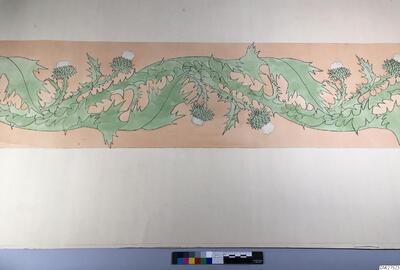


Score: 0.2736  |  _91668_GSM_objekt_28370_namnskylt.jpg


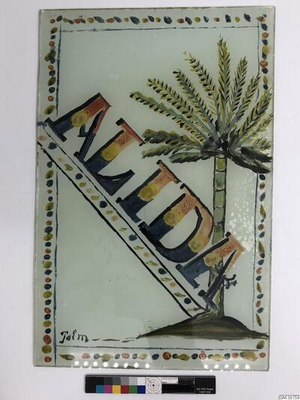


Score: 0.2714  |  _91668_GSM_objekt_8394_panel väggmålning målning painting wa


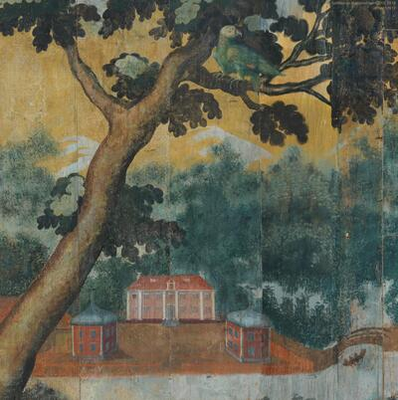


Score: 0.2684  |  _91668_GSM_objekt_413475_bilder målning akvarell.jpg


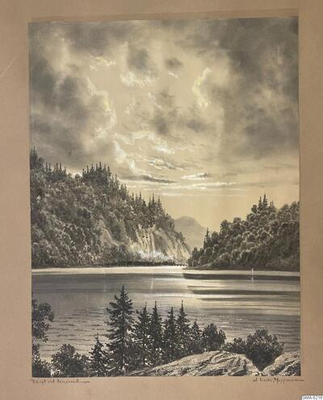


Score: 0.2671  |  _91668_GSM_objekt_28280_julgransprydnad jul KOTTE.jpg


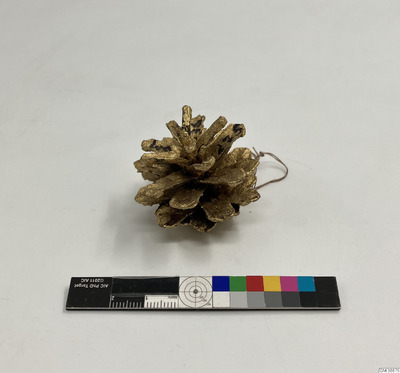

In [62]:
# Display the top 5 results as images
if CLIP_AVAILABLE and image_embeddings is not None and results:
    print(f"\n🖼️  Top results for '{SEARCH_QUERY}':\n")
    display_results(results, max_display=5)


---

## Part 7: Save Results


In [63]:
def save_search_results(results, query, output_dir=None):
    """Save search results to a JSON file."""
    output_dir = Path(output_dir or DATA_DIR)
    output_dir.mkdir(parents=True, exist_ok=True)

    safe_q    = "".join(c for c in query if c.isalnum() or c in ' _-')[:40]
    out_path  = output_dir / f"clip_search_{safe_q.replace(' ', '_')}.json"

    with open(out_path, 'w') as f:
        json.dump({
            'query':   query,
            'model':   MODEL_NAME,
            'results': [{'filename': fn, 'similarity': sc} for fn, sc in results]
        }, f, indent=2)

    print(f"✓ Saved {len(results)} results → {out_path}")


if 'results' in dir() and results:
    save_search_results(results, SEARCH_QUERY)


✓ Saved 10 results → /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/clip_search_pine_tree.json


---

## Summary

In this notebook, you:

1. **Loaded** the CLIP model (cached in `models/CLIP/` after first download)
2. **Computed** CLIP embeddings for your image collection and saved them to `.npz`
3. **Searched** using natural language — CLIP matched text to image meaning, not keywords
4. **Compared** different query phrasings and explored prompt ensembling

### Key Concepts

| Concept | Meaning |
|---------|---------|
| **Embedding** | 512-number vector encoding the "meaning" of an image or text |
| **Cosine similarity** | Dot product of two normalised vectors — how aligned they are |
| **Prompt ensembling** | Averaging multiple query embeddings for more robust search |
| **Semantic search** | Finding images by *meaning*, not by filename or tag |

### Next Steps

In **Notebook 04**, you will use an image as the query instead of text —
find museum objects that look visually similar to a photo you upload.
